# Objective
    1) Predict images with/without defect(s)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./input/train.csv')
print("train.shape:", train.shape)
train.head()

train.shape: (50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


# Preprocessing

## 1) Split into ImageId, ClassId

In [3]:
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['defect'] = train['EncodedPixels'].notnull()

train = train[['ImageId','ClassId','defect','EncodedPixels']]

In [4]:
print('{} = no. of train_images * 4'.format(train.shape[0]))
print('train.shape:', train.shape)
train.head()

50272 = no. of train_images * 4
train.shape: (50272, 4)


,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


# y_train (image with/without defect(s))

In [5]:
y_train = train.groupby(by='ImageId', axis=0, as_index=False).agg({'defect':'max'})

In [6]:
# for train_datagen.flow_from_dataframe.class_mode='binary' -> y_col has to be str

y_train['defect'] = y_train['defect'].astype(str)

In [7]:
print('There are {} train_images in total'.format(y_train.shape[0]))
print('train.shape:', y_train.shape)
y_train.head()

There are 12568 train_images in total
train.shape: (12568, 2)


,ImageId,defect
0,0002cc93b.jpg,True
1,00031f466.jpg,False
2,000418bfc.jpg,False
3,000789191.jpg,False
4,0007a71bf.jpg,True


True     6666
False    5902
Name: defect, dtype: int64
True/False Ratio: 1.129448


Text(0, 0.5, 'No. of images')

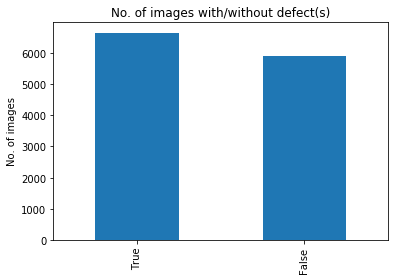

In [8]:
print(y_train['defect'].value_counts())
print('True/False Ratio: {:f}'.format(y_train['defect'].value_counts()[0]/y_train['defect'].value_counts()[1]))

y_train['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with/without defect(s)")
plt.ylabel("No. of images")

# Split y_train into y_train, y_val 

In [9]:
VALIDATION_SPLIT = 0.1

In [10]:
from sklearn.model_selection import train_test_split

y_train, y_val = train_test_split(y_train, test_size=VALIDATION_SPLIT, random_state=42)

In [11]:
print('y_train.shape:', y_train.shape)
y_train.head()

y_train.shape: (11311, 2)


,ImageId,defect
398,08a8ed239.jpg,True
9704,c5094dee9.jpg,False
908,12d720737.jpg,False
6092,7b3566fb9.jpg,True
592,0c3fdad18.jpg,False


True     5987
False    5324
Name: defect, dtype: int64
True/False Ratio: 1.124530


Text(0, 0.5, 'No. of images')

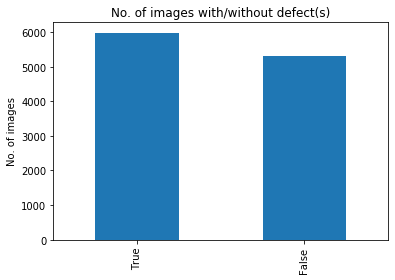

In [12]:
print(y_train['defect'].value_counts())
print('True/False Ratio: {:f}'.format(y_train['defect'].value_counts()[0]/y_train['defect'].value_counts()[1]))

y_train['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with/without defect(s)")
plt.ylabel("No. of images")

In [13]:
print('y_val.shape:', y_val.shape)
y_val.head()

y_val.shape: (1257, 2)


,ImageId,defect
7313,94947e1f9.jpg,True
2119,2aeb8dbd6.jpg,False
8214,a6ecee828.jpg,True
357,07edbd095.jpg,False
5527,6fc6a0964.jpg,True


True     679
False    578
Name: defect, dtype: int64
True/False Ratio: 1.174740


Text(0, 0.5, 'No. of images')

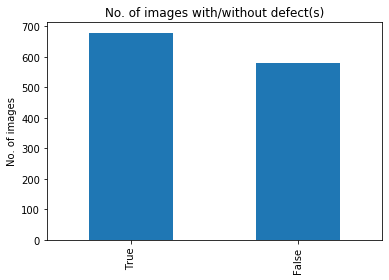

In [14]:
print(y_val['defect'].value_counts())
print('True/False Ratio: {:f}'.format(y_val['defect'].value_counts()[0]/y_val['defect'].value_counts()[1]))

y_val['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with/without defect(s)")
plt.ylabel("No. of images")

# sample_submission

In [15]:
sample_submission = pd.read_csv("./input/sample_submission.csv")
print("sample_submission.shape:", sample_submission.shape)
sample_submission.head()

sample_submission.shape: (7204, 2)


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


## 1) Split into ImageId, ClassId

In [16]:
sample_submission['ImageId'] = sample_submission['ImageId_ClassId'].str[:-2]
sample_submission['ClassId'] = sample_submission['ImageId_ClassId'].str[-1:]
sample_submission['defect'] = np.nan

sample_submission = sample_submission[['ImageId','ClassId','defect']]

In [17]:
print('{} = no. of test_images * 4'.format(sample_submission.shape[0]))
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

7204 = no. of test_images * 4
sample_submission.shape: (7204, 3)


,ImageId,ClassId,defect
0,004f40c73.jpg,1,NaN
1,004f40c73.jpg,2,NaN
2,004f40c73.jpg,3,NaN
3,004f40c73.jpg,4,NaN
4,006f39c41.jpg,1,NaN


## 2) Groupby 'ImageId'

In [18]:
sample_submission = sample_submission.groupby(by='ImageId', axis=0, as_index=False).agg({'defect':'max'})

In [19]:
print('There are {} test_images in total'.format(sample_submission.shape[0]))
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

There are 1801 test_images in total
sample_submission.shape: (1801, 2)


,ImageId,defect
0,004f40c73.jpg,NaN
1,006f39c41.jpg,NaN
2,00b7fb703.jpg,NaN
3,00bbcd9af.jpg,NaN
4,0108ce457.jpg,NaN


# ImageDataGenerator
1. Data Augmentation for train_images (i.e. rotate, shear, flip...)
2. Create flow from dataframe (Takes the dataframe and the path to a directory and generates batches of augmented/normalized data.)

In [20]:
BATCH_SIZE = 32

In [21]:
%%time
from keras.preprocessing.image import ImageDataGenerator

# Create train data generator (Data augementation: i.e. rotate, shear, flip...) 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        
        #fill_mode='constant',   # filling points outside the input boundaries with 0
        #cval=0.,
        #zoom_range=0.1,
        #rotation_range=10,
        #height_shift_range=0.1,
        #width_shift_range=0.1,
        #horizontal_flip=True,
        #vertical_flip=True
)

# Create flow from dataframe for train set
train_generator = train_datagen.flow_from_dataframe(
        y_train,
        directory = './input/train_images/',
        x_col='ImageId', 
        y_col='defect', 
        target_size = (256,256),
        color_mode = 'grayscale',
        batch_size = BATCH_SIZE,
        class_mode = 'binary',
        shuffle=True)


# Create data generator for val & test set (rescale only)
val_test_datagen = ImageDataGenerator(
        rescale=1./255
)

# Create flow from dataframe for val set
validation_generator = val_test_datagen.flow_from_dataframe(
        y_val,
        directory = './input/train_images/',
        x_col='ImageId', 
        y_col='defect',
        target_size = (256,256),
        color_mode = 'grayscale',
        batch_size = BATCH_SIZE,
        class_mode = 'binary',
        shuffle=False)

# Create flow from dataframe for test set
test_generator = val_test_datagen.flow_from_dataframe(
        sample_submission,
        directory = './input/test_images/',
        x_col='ImageId',
        target_size = (256,256),
        color_mode = 'grayscale',
        batch_size = BATCH_SIZE,
        class_mode = None,
        shuffle=False)

Using TensorFlow backend.


Found 11311 validated image filenames belonging to 2 classes.
Found 1257 validated image filenames belonging to 2 classes.
Found 1801 validated image filenames.
Wall time: 12.6 s


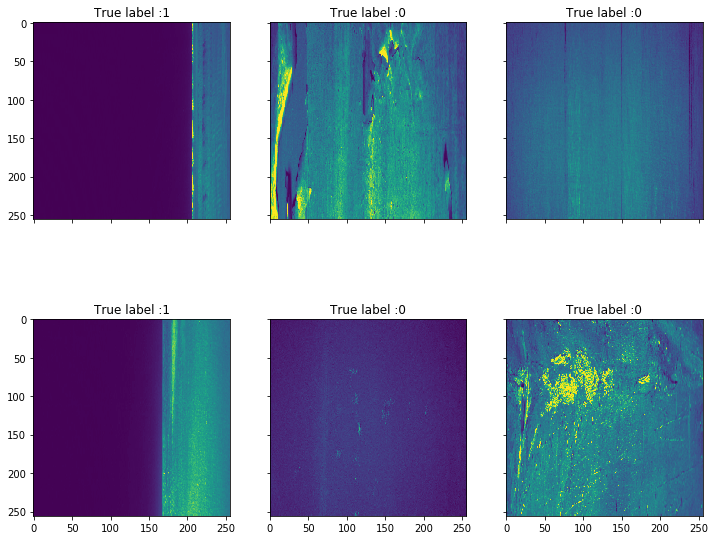

In [22]:
# show train data generator (with Data Augmentation)
nrows = 2
ncols = 3

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,10))
for row in range(nrows):
    for col in range(ncols):
        i = row * ncols + col

        ax[row,col].imshow(np.squeeze(train_generator[0][0][i]))
        ax[row,col].set_title("True label :{}".format(train_generator.classes[i]))

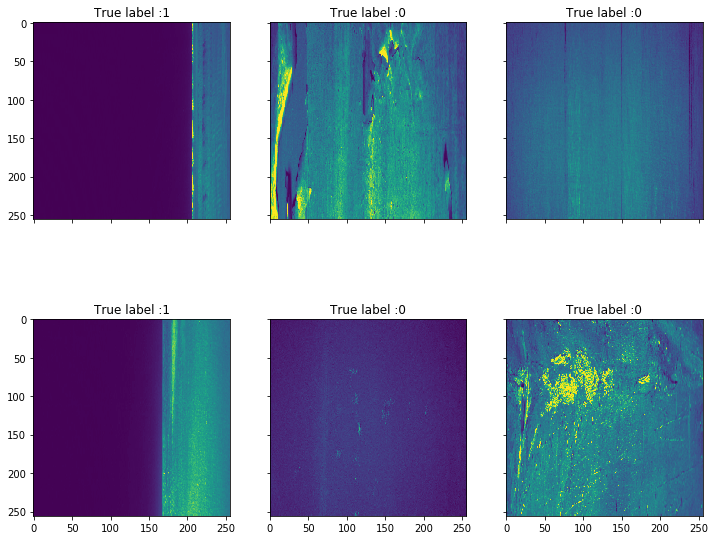

In [23]:
# show train data generator
nrows = 2
ncols = 3

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,10))
for row in range(nrows):
    for col in range(ncols):
        i = row * ncols + col

        ax[row,col].imshow(np.squeeze(train_generator[0][0][i]))
        ax[row,col].set_title("True label :{}".format(train_generator.classes[i]))

# Model in Keras

In [41]:
import keras
from keras.layers import Dropout, BatchNormalization, Flatten, Dense, GlobalMaxPooling2D
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, Input, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.applications import DenseNet121, Xception, InceptionResNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import tensorflow as tf

ImportError: cannot import name 'recall'

In [25]:
# # Set cpu cores = 1

# from keras import backend as K
# K.set_session(K.tf.Session(config=K.tf.ConfigProto(device_count = {'CPU' : 1, 'GPU': 1},
#                                                    intra_op_parallelism_threads = 4,
#                                                    inter_op_parallelism_threads = 4,
#                                                    )))

In [26]:
KEEP_PROB = 0.3

In [38]:
def Create_model():
    
    input_shape = (256,256,3)     # grayscale=(256,256,1), rgb=(256,256,3)
    
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), padding='same') (inputs)
    c1 = BatchNormalization() (c1)
    c1 = Activation('elu') (c1)
    c1 = Conv2D(8, (3, 3), padding='same') (c1)
    c1 = BatchNormalization() (c1)
    c1 = Activation('elu') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(KEEP_PROB) (p1)

    c2 = Conv2D(16, (3, 3), padding='same') (p1)
    c2 = BatchNormalization() (c2)
    c2 = Activation('elu') (c2)
    c2 = Conv2D(16, (3, 3), padding='same') (c2)
    c2 = BatchNormalization() (c2)
    c2 = Activation('elu') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(KEEP_PROB) (p2)

    c3 = Conv2D(32, (3, 3), padding='same') (p2)
    c3 = BatchNormalization() (c3)
    c3 = Activation('elu') (c3)
    c3 = Conv2D(32, (3, 3), padding='same') (c3)
    c3 = BatchNormalization() (c3)
    c3 = Activation('elu') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(KEEP_PROB) (p3)

    c4 = Conv2D(64, (3, 3), padding='same') (p3)
    c4 = BatchNormalization() (c4)
    c4 = Activation('elu') (c4)
    c4 = Conv2D(64, (3, 3), padding='same') (c4)
    c4 = BatchNormalization() (c4)
    c4 = Activation('elu') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(KEEP_PROB) (p4)

    c5 = Conv2D(64, (3, 3), padding='same') (p4)
    c5 = BatchNormalization() (c5)
    c5 = Activation('elu') (c5)
    c5 = Conv2D(64, (3, 3), padding='same') (c5)
    c5 = BatchNormalization() (c5)
    c5 = Activation('elu') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)
    p5 = Dropout(KEEP_PROB) (p5)

    c55 = Conv2D(128, (3, 3), padding='same') (p5)
    c55 = BatchNormalization() (c55)
    c55 = Activation('elu') (c55)
    c55 = Conv2D(128, (3, 3), padding='same') (c55)
    c55 = BatchNormalization() (c55)
    c55 = Activation('elu') (c55)

#     u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
#     u6 = concatenate([u6, c5])
#     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
#     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

#     u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
#     u71 = concatenate([u71, c4])
#     c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
#     c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

#     u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
#     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

#     u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
#     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

#     u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
#     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)
    
#     c9 = Conv2D(4, (1, 1), activation='sigmoid') (c9)
    
#     outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    x1 = GlobalMaxPooling2D() (c55)
    x1 = BatchNormalization() (x1)
    x1 = Dropout(KEEP_PROB) (x1)
    
    outputs = Dense(1, activation = 'sigmoid') (x1)
    
#     x1 = GlobalAveragePooling2D() (c9)
#     x1 = BatchNormalization() (x1)
#     x1 = Dropout(KEEP_PROB) (x1)
    
#     x2 = Dense(2048, activation = 'relu') (x1)
#     x2 = BatchNormalization() (x2)
#     x2 = Dropout(KEEP_PROB) (x2)
    
#     x3 = Dense(512, activation = 'relu') (x2)
#     x3 = BatchNormalization() (x3)
#     x3 = Dropout(KEEP_PROB) (x3)
    
#     outputs = Dense(1, activation = 'sigmoid') (x3)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    adam = Adam(lr=0.0005)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [39]:
def Load_model():
    keras.backend.clear_session()
    
    model = load_model('./model/step1_rgb_unet_valacc_0.9634.h5')
    #model.layers[0].trainable = False
    
    adam = Adam(lr=0.00000001)
    
    model.compile(
            optimizer = adam,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])
    
    model.summary()
    
    return model

In [40]:
%%time
# Create model
model = Create_model()

# Load model
# model = Load_model()

NameError: name 'recall' is not defined

In [37]:
# Define callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
# ModelCheckpoint: Save the (best) model weights after every epoch

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
             EarlyStopping(monitor='val_loss', patience=6, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, cooldown=1, min_lr=1e-6),
             ModelCheckpoint(filepath='./model/step1_rgb_unet_valacc.h5', monitor='val_loss',
                             save_best_only=True, save_weights_only=False)
            ]

In [38]:
EPOCHS = 60

total_steps = y_train.shape[0] / BATCH_SIZE                # no. of train_images / batch size

train_steps = int(np.ceil(y_train.shape[0] / BATCH_SIZE))
validation_steps = int(np.ceil(y_val.shape[0] / BATCH_SIZE))
print('train_steps:', train_steps)                         # len(train_generator)
print('validation_steps:', validation_steps)               # len(validation_generator)

train_steps: 354
validation_steps: 40


In [39]:
%%time
# Train the model

history = model.fit_generator(
                train_generator,
                steps_per_epoch = train_steps,
                epochs = EPOCHS,
                validation_data = validation_generator,
                validation_steps = validation_steps,
                callbacks = callbacks,
                workers=16,
                max_queue_size=50
                )

Epoch 1/60
354/354 [==============================] - 60s 169ms/step - loss: 0.5654 - acc: 0.7127 - val_loss: 0.6846 - val_acc: 0.5155
Epoch 2/60
354/354 [==============================] - 49s 138ms/step - loss: 0.4488 - acc: 0.7870 - val_loss: 0.5394 - val_acc: 0.7279
Epoch 3/60
354/354 [==============================] - 49s 138ms/step - loss: 0.3972 - acc: 0.8159 - val_loss: 0.6501 - val_acc: 0.7072
Epoch 4/60
354/354 [==============================] - 49s 138ms/step - loss: 0.3665 - acc: 0.8336 - val_loss: 0.4289 - val_acc: 0.7884
Epoch 5/60
354/354 [==============================] - 49s 137ms/step - loss: 0.3377 - acc: 0.8507 - val_loss: 0.3648 - val_acc: 0.8496
Epoch 6/60
354/354 [==============================] - 49s 137ms/step - loss: 0.3143 - acc: 0.8664 - val_loss: 0.3368 - val_acc: 0.8425
Epoch 7/60
354/354 [==============================] - 49s 138ms/step - loss: 0.2960 - acc: 0.8732 - val_loss: 0.5326 - val_acc: 0.7828
Epoch 8/60
354/354 [==============================] - 4

In [27]:
# Save model
model.save('./model/step1_rgb_unet_valacc.h5')

In [40]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


# Model Evaluation

## Plot Learning rate

learning rate: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.00036, 0.00036, 0.00036, 0.000216, 0.000216, 0.000216, 0.000216, 0.000216, 0.0001296, 0.0001296, 0.0001296, 0.0001296, 7.776e-05, 7.776e-05, 4.6656e-05, 4.6656e-05]


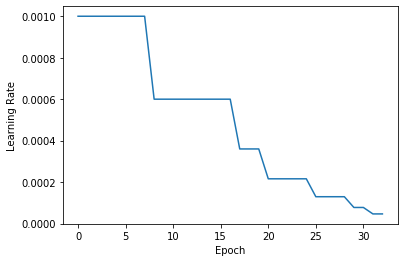

In [41]:
print('learning rate:', history.history['lr'])
plt.plot(history.history['lr'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

## 1) Plot loss and accuracy (train, val)

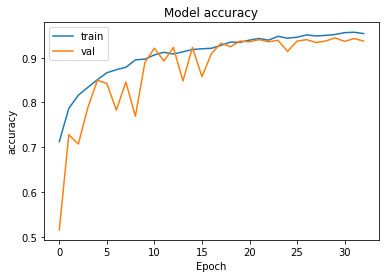

In [42]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.show()

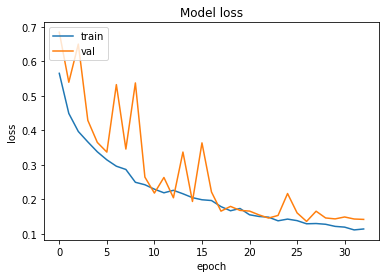

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 2) Loss and accuracy (val)

In [44]:
%%time

validation_generator.reset()
# score = model.evaluate(x_val, y_val)
score = model.evaluate_generator(validation_generator, steps = validation_steps)
print("loss:", score[0])
print("metric (accuracy): ", score[1])

loss: 0.1415688046235695
metric (accuracy):  0.9371519490851233
Wall time: 9.68 s


## 3) ROC AUC (val)

In [45]:
df_val = y_val
df_val

,ImageId,defect
7313,94947e1f9.jpg,True
2119,2aeb8dbd6.jpg,False
8214,a6ecee828.jpg,True
357,07edbd095.jpg,False
5527,6fc6a0964.jpg,True
2865,39b187684.jpg,False
6826,8ab0bf58c.jpg,False
2310,2ec116cea.jpg,True
8814,b2b1349c7.jpg,False
12523,feebe80d4.jpg,True


In [46]:
validation_generator.classes[:5]

[1, 0, 1, 0, 1]

In [47]:
validation_generator.filenames[:5]

['94947e1f9.jpg',
 '2aeb8dbd6.jpg',
 'a6ecee828.jpg',
 '07edbd095.jpg',
 '6fc6a0964.jpg']

In [48]:
%%time

validation_generator.reset()
# y_val_pred = model.predict_classes(x_val)
y_val_pred_prob = model.predict_generator(validation_generator, steps = validation_steps)

Wall time: 9.71 s


In [49]:
print('y_val_pred_prob.shape:', y_val_pred_prob.shape)
y_val_pred_prob

y_val_pred_prob.shape: (1257, 1)


array([[0.9993582 ],
       [0.5342585 ],
       [0.99668276],
       ...,
       [0.00167531],
       [0.9985738 ],
       [0.9928837 ]], dtype=float32)

In [50]:
y_val_pred = y_val_pred_prob > 0.5
y_val_pred

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [ True],
       [ True]])

In [51]:
y_val = np.array(validation_generator.classes)
print('y_val.shape:', y_val.shape)
y_val

y_val.shape: (1257,)


array([1, 0, 1, ..., 0, 1, 1])

In [52]:
from sklearn.metrics import roc_auc_score

print('ROC AUC (val): {0}'.format(roc_auc_score(y_val, y_val_pred)))

ROC AUC (val): 0.9351351213620681


## 4) Error Distribution

In [53]:
uniqueValues, occurCount = np.unique(y_val_pred, return_counts=True)

uniqueValues[0], uniqueValues[1] = uniqueValues[1], uniqueValues[0]     #reorder
occurCount[0], occurCount[1] = occurCount[1], occurCount[0]

print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [ True False]
Occurrence Count :  [704 553]


True/False Ratio: 1.273056


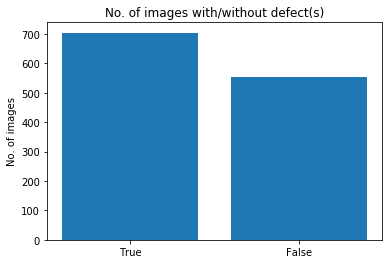

In [54]:
plt.bar(x = (str(uniqueValues[0]), str(uniqueValues[1])), height = occurCount)
plt.title("No. of images with/without defect(s)")
plt.ylabel("No. of images")
print('True/False Ratio: {:f}'.format(occurCount[0]/occurCount[1]))

## 5) Plot confusion matrix (val)

In [55]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, vmax=None, normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    print('confusion_matrix:\n', matrix)
    
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    fig = sns.heatmap(matrix, vmax=vmax, annot=True, square=True,
                cmap=plt.cm.Blues_r, cbar=False, linecolor='black', linewidths=1,
                xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(title)
    plt.show(fig)

confusion_matrix:
 [[526  52]
 [ 27 652]]


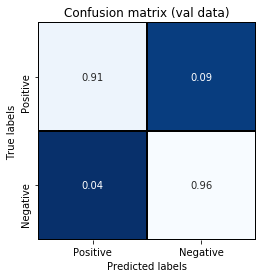

In [56]:
plot_confusion_matrix(y_val, y_val_pred,
                      class_names=['Positive', 'Negative'],
                      title='Confusion matrix (val data)')

## 6) Plot errors

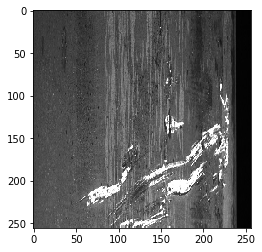

In [57]:
# image from validation_generator
validation_generator[38][0][31].shape   #1st[]: [0:39] no. of batch    2nd[]: [0/1] x/y    3nd[]: [0:32] no. of image in a batch
plt.imshow(np.squeeze(validation_generator[38][0][31]))

In [58]:
# last batch (40th): 9 images
validation_generator[39][0].shape

(9, 256, 256, 3)

In [59]:
# 1 batch = 32 images
validation_generator[0][0][:].shape

(32, 256, 256, 3)

In [60]:
%%time
x_val = np.concatenate([validation_generator[batch][0][:] for batch in range(len(validation_generator))])   # from 0 to 39
print('x_val.shape:', x_val.shape)

x_val.shape: (1257, 256, 256, 3)
Wall time: 9.96 s


Total no. of error in val set: 79
First 6 error index: [ 1  7 14 56 61 72]


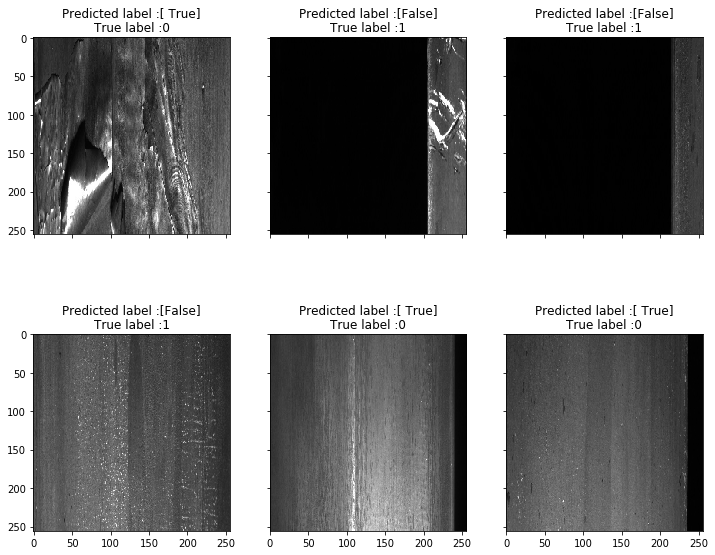

In [61]:
errors = (np.squeeze(y_val_pred) - y_val != 0) # array of bools with true when there is an error or false when the image is cor

index = np.squeeze(np.where(errors==True))
print('Total no. of error in val set:', len(index))
print('First 6 error index:', index[:6])

y_val_pred_er = y_val_pred[errors]
y_val_er = y_val[errors]
x_val_er = x_val[errors]

def display_errors():
    """ This function shows 6 images with their predicted and real labels"""
    nrows = 2
    ncols = 3
    
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,10))
    for row in range(nrows):
        for col in range(ncols):
            i = row * ncols + col
            
            ax[row,col].imshow(np.squeeze(x_val_er[i], ))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(y_val_pred_er[i], y_val_er[i]))

# Show the 6 errors
display_errors()

# Prediction

In [62]:
test_steps = int(np.ceil(sample_submission.shape[0] / BATCH_SIZE))           # no. of test_images / batch size
print('test_steps:', test_steps)                                             # len(test_generator)

test_steps: 57


In [63]:
%%time

test_generator.reset()
y_pred_prob = model.predict_generator(test_generator, steps = test_steps)

Wall time: 12.7 s


In [64]:
print('y_pred_prob.shape:', y_pred_prob.shape)
y_pred_prob

y_pred_prob.shape: (1801, 1)


array([[5.5685729e-02],
       [8.7505656e-01],
       [4.2956707e-01],
       ...,
       [9.9741131e-01],
       [8.8202953e-04],
       [9.9653792e-01]], dtype=float32)

In [65]:
y_pred = y_pred_prob > 0.5
y_pred

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [ True]])

# Sample_submission
    sample_submission['defect'] = y_pred

In [66]:
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (1801, 2)


,ImageId,defect
0,004f40c73.jpg,NaN
1,006f39c41.jpg,NaN
2,00b7fb703.jpg,NaN
3,00bbcd9af.jpg,NaN
4,0108ce457.jpg,NaN


In [67]:
sample_submission['defect'] = y_pred

In [68]:
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (1801, 2)


,ImageId,defect
0,004f40c73.jpg,False
1,006f39c41.jpg,True
2,00b7fb703.jpg,False
3,00bbcd9af.jpg,True
4,0108ce457.jpg,False


In [69]:
sample_submission.isnull().sum()

ImageId    0
defect     0
dtype: int64

True     1113
False     688
Name: defect, dtype: int64
True/False Ratio: 1.617733


Text(0, 0.5, 'No. of images')

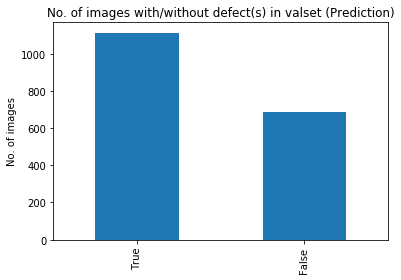

In [70]:
print(sample_submission['defect'].value_counts())
print('True/False Ratio: {:f}'.
      format(sample_submission['defect'].value_counts()[1]/sample_submission['defect'].value_counts()[0]))

sample_submission['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with/without defect(s) in valset (Prediction)")
plt.ylabel("No. of images")

In [71]:
sample_submission.to_csv('./output/submission_step1_rgb.csv', index=False)

# Plot Model png

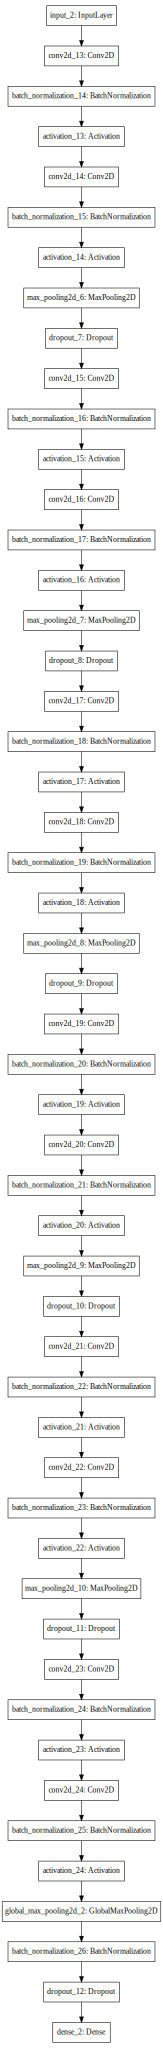

In [101]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='./output/model_step1_rgb.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))